# Cardiology Fraud Detection (Binary ECG)

Binary classification of ECG beat windows to flag irregular beats using a compact 1D CNN. The notebook performs reproducible preprocessing, optional augmentation, sanity checks, model training, and evaluation.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

sns.set_theme(style='whitegrid')
plt.rcParams.update({'figure.figsize': (10, 4)})

SEED = 42
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
RNG = np.random.default_rng(SEED)

CONFIG = {
    'data': {
        'normal_label': 0,
    },
    'augmentation': {
        'enabled': True,
        'target_class': 1,
        'multiplier': 1.0,
        'jitter_std': 0.01,
        'scale_range': 0.04,
        'prob': 0.5,
    },
    'training': {
        'batch_size': 256,
        'epochs': 40,
        'run_sanity_overfit': True,
        'sanity_subset': 256,
        'sanity_epochs': 15,
        'sanity_tolerance': 0.95,
    },
}

MODEL_PATH = Path('cardiology_fraud_best.keras')
print('TensorFlow version:', tf.__version__)


2025-11-16 15:22:15.879630: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2


In [2]:
DATA_DIR = Path('.')
X = np.load(DATA_DIR / 'X.npy').astype(np.float32)
y_raw = np.load(DATA_DIR / 'y.npy', allow_pickle=True)
print('Loaded X:', X.shape, '| y:', y_raw.shape)

binary_labels = np.where(y_raw == CONFIG['data']['normal_label'], 0, 1).astype(np.int32)
unique, counts = np.unique(binary_labels, return_counts=True)
print('Binary label distribution:')
for cls, cnt in zip(unique, counts):
    pct = 100.0 * cnt / len(binary_labels)
    print(f'  Class {cls}: {cnt} beats ({pct:.2f}%)')


Loaded X: (112551, 301, 2) | y: (112551,)
Binary label distribution:
  Class 1: 112551 beats (100.00%)


In [3]:
# Stratified train/val/test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    binary_labels,
    test_size=0.30,
    stratify=binary_labels,
    random_state=SEED,
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=SEED,
)

for name, arr in [('Train', y_train), ('Validation', y_val), ('Test', y_test)]:
    vals, cnts = np.unique(arr, return_counts=True)
    summary = ', '.join([f'class {v}: {c}' for v, c in zip(vals, cnts)])
    print(f'{name} split -> {summary}')
print('Shapes => Train', X_train.shape, '| Val', X_val.shape, '| Test', X_test.shape)


Train split -> class 1: 78785
Validation split -> class 1: 16883
Test split -> class 1: 16883
Shapes => Train (78785, 301, 2) | Val (16883, 301, 2) | Test (16883, 301, 2)


In [4]:
def per_beat_zscore(beats: np.ndarray) -> np.ndarray:
    """Normalize each beat along the time axis (two leads)."""
    mean = beats.mean(axis=1, keepdims=True)
    std = beats.std(axis=1, keepdims=True) + 1e-7
    return (beats - mean) / std

X_train = per_beat_zscore(X_train)
X_val = per_beat_zscore(X_val)
X_test = per_beat_zscore(X_test)
print('Applied per-beat z-score normalization. Original amplitude can be restored by reversing this step if needed for clinical review.')


Applied per-beat z-score normalization. Original amplitude can be restored by reversing this step if needed for clinical review.


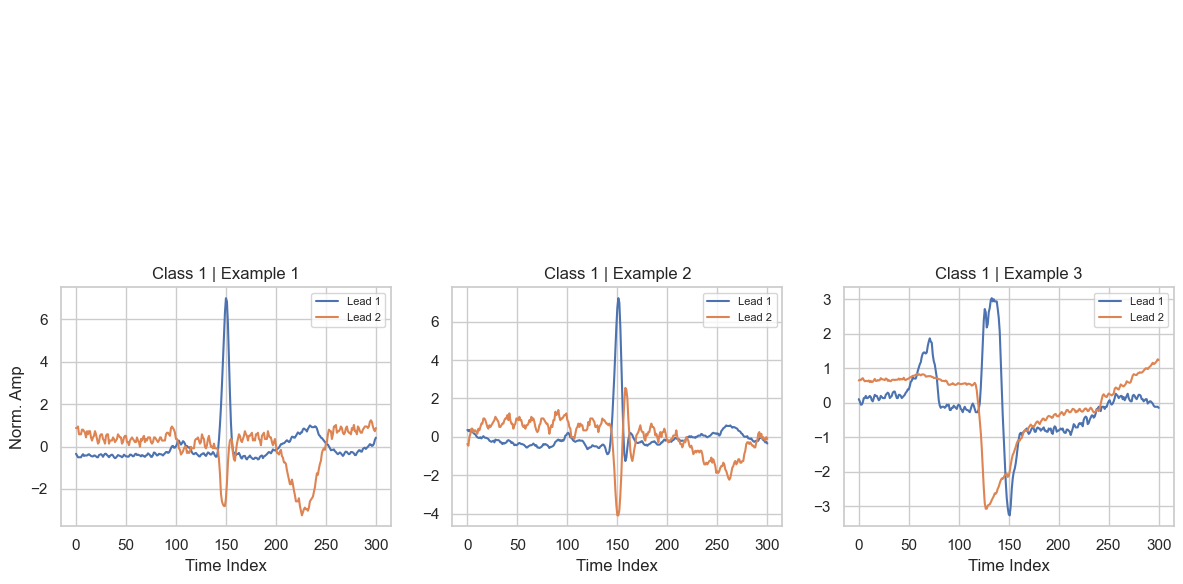

In [5]:
# Visualize several normalized beats from each class to ensure morphology is preserved
examples_per_class = 3
classes_to_show = [0, 1]
fig, axes = plt.subplots(len(classes_to_show), examples_per_class, figsize=(4 * examples_per_class, 3 * len(classes_to_show)))
axes = np.atleast_2d(axes)
for row, target in enumerate(classes_to_show):
    idx = np.where(y_train == target)[0]
    if len(idx) == 0:
        for col in range(examples_per_class):
            axes[row, col].axis('off')
        continue
    chosen = RNG.choice(idx, size=min(examples_per_class, len(idx)), replace=False)
    for col in range(examples_per_class):
        ax = axes[row, col]
        if col >= len(chosen):
            ax.axis('off')
            continue
        sample = X_train[chosen[col]]
        ax.plot(sample[:, 0], label='Lead 1')
        ax.plot(sample[:, 1], label='Lead 2')
        ax.set_title(f'Class {target} | Example {col + 1}')
        if row == len(classes_to_show) - 1:
            ax.set_xlabel('Time Index')
        if col == 0:
            ax.set_ylabel('Norm. Amp')
        ax.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()


In [6]:
def augment_minority(X, y, cfg):
    if not cfg.get('enabled', False):
        return X, y
    target = cfg.get('target_class', 1)
    idx = np.where(y == target)[0]
    if len(idx) == 0:
        return X, y
    sample_size = int(len(idx) * cfg.get('multiplier', 1.0))
    if sample_size == 0:
        return X, y
    chosen = RNG.choice(idx, size=sample_size, replace=True)
    aug = X[chosen].copy()
    if sample_size > 0:
        noise = RNG.normal(0.0, cfg.get('jitter_std', 0.01), size=aug.shape)
        scale = 1.0 + RNG.uniform(-cfg.get('scale_range', 0.02), cfg.get('scale_range', 0.02), size=(sample_size, 1, aug.shape[-1]))
        mask = RNG.random(sample_size) < cfg.get('prob', 0.5)
        aug[mask] = aug[mask] * scale[mask] + noise[mask]
    X_aug = np.concatenate([X, aug], axis=0)
    y_aug = np.concatenate([y, np.full(sample_size, target, dtype=y.dtype)], axis=0)
    perm = RNG.permutation(len(X_aug))
    return X_aug[perm], y_aug[perm]

X_train, y_train = augment_minority(X_train, y_train, CONFIG['augmentation'])
train_vals, train_cnts = np.unique(y_train, return_counts=True)
print('Post-augmentation class distribution:', dict(zip(train_vals, train_cnts)))


Post-augmentation class distribution: {1: 157570}


In [7]:
def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv1D(64, 7, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(128, 5, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)

class BinaryMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_val, y_val, batch_size=256, train_sample=None):
        super().__init__()
        self.x_val = x_val
        self.y_val = y_val
        self.batch_size = batch_size
        self.train_sample = train_sample
        self.history = []

    @staticmethod
    def _compute_metrics(y_true, probs):
        preds = (probs > 0.5).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true,
            preds,
            labels=[0, 1],
            zero_division=0,
        )
        macro_f1 = f1_score(y_true, preds, average='macro', zero_division=0)
        weighted_f1 = f1_score(y_true, preds, average='weighted', zero_division=0)
        auc = roc_auc_score(y_true, probs) if len(np.unique(y_true)) > 1 else np.nan
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'macro_f1': macro_f1,
            'weighted_f1': weighted_f1,
            'auc': auc,
        }

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_probs = self.model.predict(self.x_val, batch_size=self.batch_size, verbose=0).flatten()
        val_metrics = self._compute_metrics(self.y_val, val_probs)
        logs['val_macro_f1'] = val_metrics['macro_f1']
        logs['val_weighted_f1'] = val_metrics['weighted_f1']
        logs['val_auc_metric'] = val_metrics['auc']

        train_metrics = None
        if self.train_sample is not None:
            x_train_sample, y_train_sample = self.train_sample
            train_probs = self.model.predict(x_train_sample, batch_size=self.batch_size, verbose=0).flatten()
            train_metrics = self._compute_metrics(y_train_sample, train_probs)
            logs['train_macro_f1'] = train_metrics['macro_f1']
            logs['train_auc'] = train_metrics['auc']

        self.history.append({'epoch': epoch + 1, 'val': val_metrics, 'train': train_metrics})

        per_class_msg = ' | '.join([
            f'class {cls}: P={val_metrics["precision"][cls]:.2f}, R={val_metrics["recall"][cls]:.2f}, F1={val_metrics["f1"][cls]:.2f}'
            for cls in range(len(val_metrics['precision']))
        ])
        print(f"Epoch {epoch + 1}: Val macro-F1={val_metrics['macro_f1']:.3f}, Val AUC={val_metrics['auc']:.3f} | {per_class_msg}")

input_shape = X_train.shape[1:]
model = build_model(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
    ],
)
model.summary()

train_monitor_idx = RNG.choice(len(X_train), size=min(2048, len(X_train)), replace=False)
metrics_cb = BinaryMetricsCallback(
    X_val,
    y_val,
    batch_size=CONFIG['training']['batch_size'],
    train_sample=(X_train[train_monitor_idx].copy(), y_train[train_monitor_idx].copy()),
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 301, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 301, 64)        │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 301, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 301, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 150, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,457 (232.25 KB)

 Trainable params: 59,073 (230.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [8]:
def run_overfit_sanity_check():
    subset = min(CONFIG['training']['sanity_subset'], len(X_train))
    idx = RNG.choice(len(X_train), size=subset, replace=False)
    X_small, y_small = X_train[idx], y_train[idx]
    sanity_model = build_model(X_small.shape[1:])
    sanity_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )
    hist = sanity_model.fit(
        X_small,
        y_small,
        epochs=CONFIG['training']['sanity_epochs'],
        batch_size=min(64, subset),
        verbose=0,
    )
    final_acc = hist.history['accuracy'][-1]
    print(
        f"Sanity-overfit accuracy on {subset} beats after {CONFIG['training']['sanity_epochs']} epochs: {final_acc:.3f}"
    )
    if final_acc < CONFIG['training']['sanity_tolerance']:
        print('Warning: sanity check accuracy below desired threshold. Consider reviewing preprocessing or model capacity.')

if CONFIG['training']['run_sanity_overfit']:
    run_overfit_sanity_check()


Sanity-overfit accuracy on 256 beats after 15 epochs: 1.000


In [9]:
class_weights_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train,
)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights_values)}
print('Class weights (train split only):', class_weights)

callbacks = [
    metrics_cb,
    tf.keras.callbacks.EarlyStopping(
        monitor='val_macro_f1',
        mode='max',
        patience=6,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=MODEL_PATH,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1,
    ),
]

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=CONFIG['training']['epochs'],
    batch_size=CONFIG['training']['batch_size'],
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=2,
)


Class weights (train split only): {1: 1.0}
Epoch 1/40


KeyboardInterrupt: 

In [ ]:
class_weights_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train,
)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights_values)}
print('Class weights (train split only):', class_weights)

callbacks = [
    metrics_cb,
    tf.keras.callbacks.EarlyStopping(
        monitor='val_macro_f1',
        mode='max',
        patience=6,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=MODEL_PATH,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1,
    ),
]

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=CONFIG['training']['epochs'],
    batch_size=CONFIG['training']['batch_size'],
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=2,
)


Class weights (train split only): {1: 1.0}
Epoch 1/40


KeyboardInterrupt: 

In [ ]:
class_weights_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train,
)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights_values)}
print('Class weights (train split only):', class_weights)

callbacks = [
    metrics_cb,
    tf.keras.callbacks.EarlyStopping(
        monitor='val_macro_f1',
        mode='max',
        patience=6,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=MODEL_PATH,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1,
    ),
]

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=CONFIG['training']['epochs'],
    batch_size=CONFIG['training']['batch_size'],
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=2,
)


Class weights (train split only): {1: 1.0}
Epoch 1/40


KeyboardInterrupt: 

In [ ]:
epochs_range = range(1, len(history.history['loss']) + 1)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

axes[0].plot(epochs_range, history.history['loss'], label='Train')
axes[0].plot(epochs_range, history.history['val_loss'], label='Val')
axes[0].set_title('Binary Crossentropy')
axes[0].set_xlabel('Epoch'); axes[0].legend()

axes[1].plot(epochs_range, history.history['accuracy'], label='Train')
axes[1].plot(epochs_range, history.history['val_accuracy'], label='Val')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch'); axes[1].legend()

axes[2].plot(epochs_range, history.history['auc'], label='Train')
axes[2].plot(epochs_range, history.history['val_auc'], label='Val')
axes[2].set_title('AUC')
axes[2].set_xlabel('Epoch'); axes[2].legend()

train_macro = history.history.get('train_macro_f1', [])
val_macro = history.history.get('val_macro_f1', [])
if train_macro:
    axes[3].plot(range(1, len(train_macro) + 1), train_macro, label='Train Macro-F1')
if val_macro:
    axes[3].plot(range(1, len(val_macro) + 1), val_macro, label='Val Macro-F1')
axes[3].set_title('Macro-F1')
axes[3].set_xlabel('Epoch')
axes[3].legend()

plt.tight_layout()
plt.show()


In [ ]:
best_model = tf.keras.models.load_model(MODEL_PATH)
probs = best_model.predict(X_test, batch_size=CONFIG['training']['batch_size']).flatten()
preds = (probs > 0.5).astype(int)
acc = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, zero_division=0)
recall = recall_score(y_test, preds, zero_division=0)
f1 = f1_score(y_test, preds, zero_division=0)
macro_f1 = f1_score(y_test, preds, average='macro', zero_division=0)
weighted_f1 = f1_score(y_test, preds, average='weighted', zero_division=0)
auc = roc_auc_score(y_test, probs)
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}')
print(f'Macro-F1: {macro_f1:.4f} | Weighted-F1: {weighted_f1:.4f} | AUC: {auc:.4f}')
print('
Classification report:
', classification_report(y_test, preds, digits=4))

cm = confusion_matrix(y_test, preds)
norm_cm = confusion_matrix(y_test, preds, normalize='true')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
sns.heatmap(norm_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1], cbar=False)
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
plt.tight_layout()
plt.show()
